"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum

[50 84]
[  0  50  84 100]
[[0.03540795 0.71385663 0.03920746]
 [0.92300848 0.67623977 0.80373562]
 [0.7340725  0.37210465 0.0502808 ]
 [0.0382183  0.56846045 0.577065  ]
 [0.39462099 0.35806963 0.93136444]]
(5, 100)


Text(0, 0.5, 'Spikes')

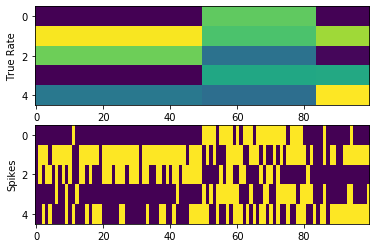

In [48]:
# Some poisson spiking
length = 100
states = 3
nrns = 5
fit = int(1e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random(states))
true_tau /= np.max(true_tau)
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)
state_inds = np.concatenate([np.zeros((1)),true_tau])
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

true_lambda = np.random.random((nrns,states))

print(true_tau)
print(state_inds)
print(true_lambda)

true_r = np.zeros((nrns,length))
for num, val in enumerate(true_lambda.T):
    true_r[:,state_inds[num]:state_inds[num+1]] = val[:,np.newaxis]
  
data_vec = np.random.random((nrns,length)) < true_r
print(data_vec.shape)
#data_vec = np.random.poisson(true_r)

fig,ax = plt.subplots(2,1)
ax[0].imshow(true_r,aspect='auto')
ax[1].imshow(data_vec,aspect='auto')
ax[0].set_ylabel("True Rate")
ax[1].set_ylabel("Spikes")

In [49]:
mean_vals = np.array([np.mean(x,axis=-1) for x in np.array_split(data_vec,states,axis=-1)]).T
print(mean_vals)

[[0.02941176 0.39393939 0.42424242]
 [0.82352941 0.75757576 0.63636364]
 [0.58823529 0.48484848 0.15151515]
 [0.08823529 0.33333333 0.48484848]
 [0.32352941 0.48484848 0.6969697 ]]


In [50]:
with pm.Model() as model:
    # Finite, but somewhere on the lower end, Beta prior
    a_lambda = 2
    b_lambda = 5
    lambda_latent = pm.Beta('lambda', 
                                    a_lambda, b_lambda, 
                                    shape = (nrns,states),
                                  testval = mean_vals + 1e-3)

    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [51]:
with model:
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((1,length)),weight_stack],axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((1,length))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)

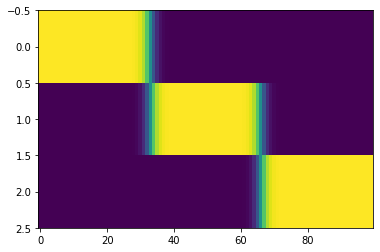

In [52]:
plt.imshow(weight_stack.tag.test_value,aspect='auto')

In [53]:
print(weight_stack.tag.test_value.shape)
print(lambda_latent.tag.test_value.shape)

(3, 100)
(5, 3)


In [54]:
with model:
    lambda_ = lambda_latent.dot(weight_stack)

(5, 100)


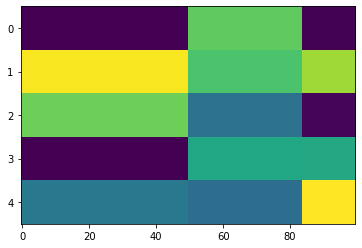

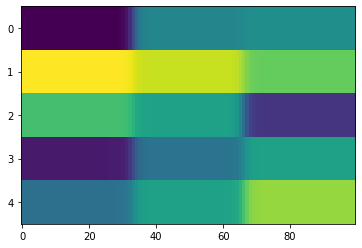

In [55]:
plt.imshow(true_r,aspect='auto')
plt.figure()
plt.imshow(lambda_.tag.test_value, aspect='auto')
print(lambda_.tag.test_value.shape)

In [56]:
with model:
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_vec)

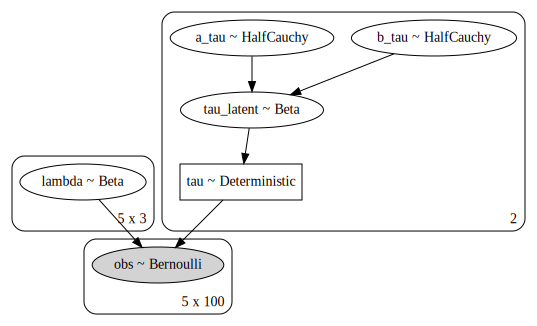

In [57]:
pm.model_to_graphviz(model)

In [58]:
with model:
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=fit, method=inference,
                   random_seed = 3,
                   obj_n_mc = 1)
    trace = approx.sample(draws=samples)

Average Loss = 290.45: 100%|██████████| 100000/100000 [00:31<00:00, 3209.70it/s]
Finished [100%]: Average Loss = 290.46


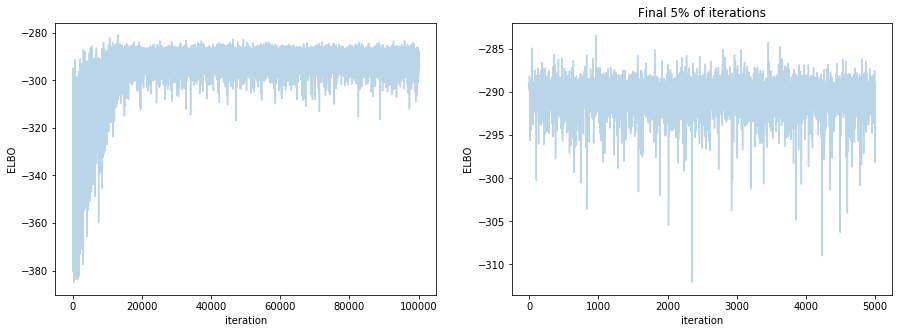

In [59]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [60]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

100%|██████████| 2000/2000 [00:01<00:00, 1324.16it/s]


Text(0.5, 1.0, 'Mean prediction')

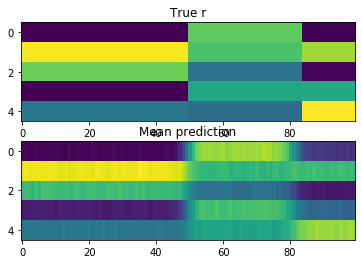

In [61]:
fig,ax = plt.subplots(2,1,sharey=True)
ax[0].imshow(true_r,aspect='auto')
ax[1].imshow(np.mean(ppc['obs'],axis=0), aspect='auto')
ax[0].set_title('True r')
ax[1].set_title('Mean prediction')

In [62]:
#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
print(tau.shape)
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
mode_tau

(2000, 2)


array([49, 81])

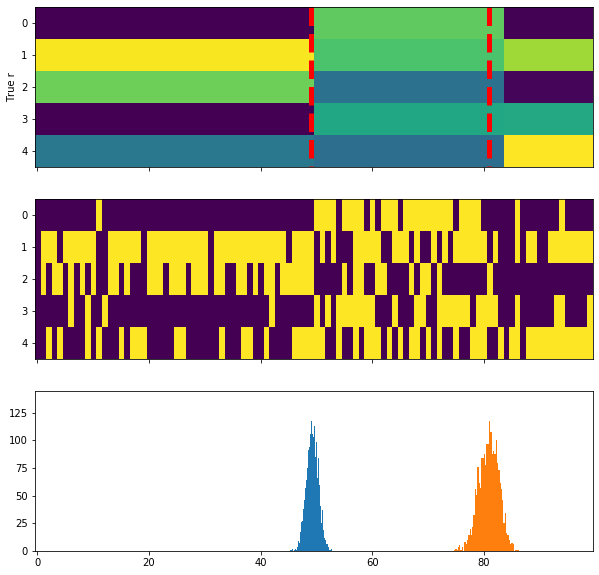

In [63]:
fig,ax = plt.subplots(3,1,sharex=True,figsize=(10,10))
ax[0].imshow(true_r,aspect='auto')
ax[0].set_ylabel('True r')
ax[1].imshow(data_vec,aspect='auto')
    
for tau_num, this_tau in enumerate(tau.T):
    ax[2].hist(this_tau,bins=50)
    ax[0].vlines(mode_tau[tau_num],-0.5,nrns-0.5,color='red',alpha=1,linewidth=5, linestyles='dashed')
